# **Accelerated SGD**

In [1]:
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

Continuing from the previous NB, we will push to improve the model's performance beyong 90%. 

## **Import Data and Setup**

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu)) # Using GeneralRelu from before
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## **Optimizers**

### **Custom SGD Class**

In [8]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params) # module.params returns a generator, so we'll use list()
        fc.store_attr()
        self.i = 0 # track batch numbers

    def step(self):
        with torch.no_grad():
            for p in self.params:
                # For each tensor of params do one step of the regularizer and one step for the optimizer.
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1 # track batches

    def opt_step(self, p): p -= p.grad * self.lr # From the parameter subtract the gradient from the learning rate 

    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_() # For each param zero the gradients

In [9]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.824,0.477,0,eval
0.845,0.424,1,train
0.849,0.418,1,eval
0.865,0.371,2,train
0.847,0.415,2,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


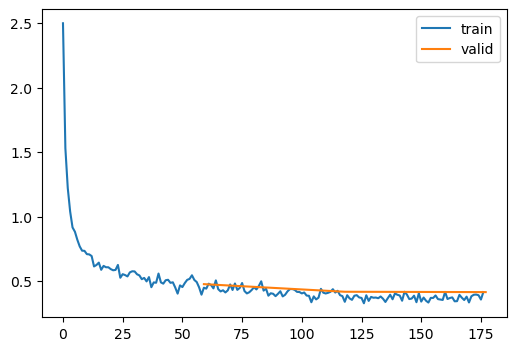

In [10]:
learn.fit(3)

## **Momentum Revisited**

In [5]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3)**2 + torch.randn(100) * 0.1

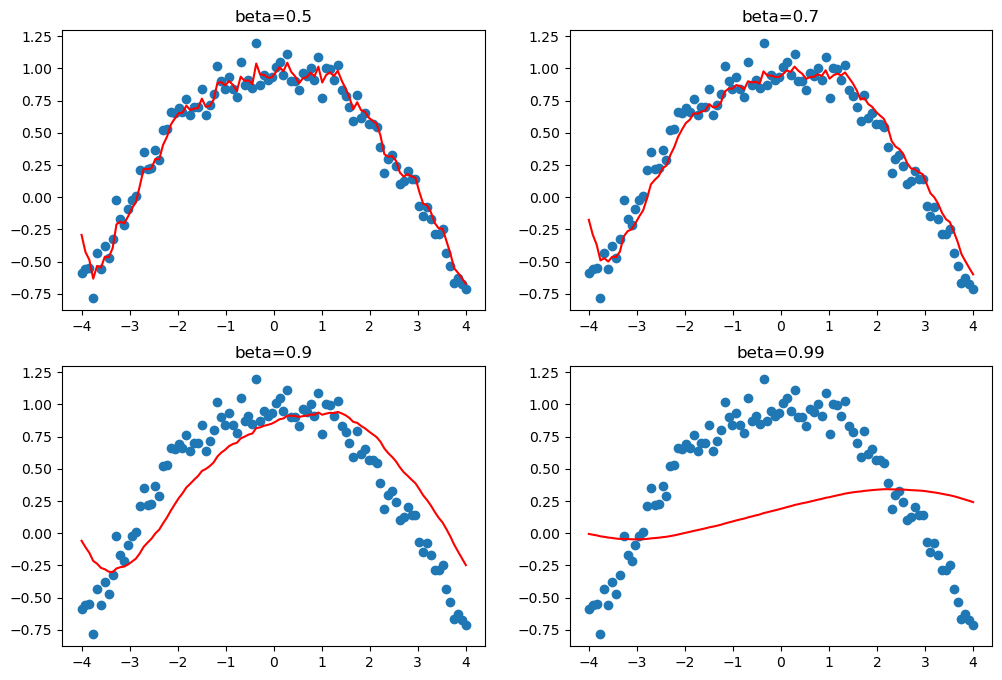

In [7]:
_, axs = plt.subplots(2, 2, figsize=(12, 8))
betas = [0.5, 0.7, 0.9, 0.99]

for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs, np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9): # As before, FastAI's momentum is the opposite of PyTorch's implementation
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg        

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainerLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

In [ ]:
learn.fit(3)

In [ ]:
astats.color_dim()

In [ ]:
astats.plot_stats()

## **RMS Prop**

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

In [ ]:
astats.color_dim()

In [ ]:
astats.plot_stats()

## **Adam**

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'):     p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))
        p -+ self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)